#### In the name of god
# Predicting the Thermodynamic Properties of Water-Ethanol Mixture using Machine Learning
#### School Of Chemical Engineering<br>College Of Engineering<br>University Of Tehran
Prepared By:<br>Zahra Mabodi<br>Seyed Reza Hosseini<br>Mohammad Mahdi Mohammadi<br><br>
Supervisors:<br>Dr.Bahramian<br>Dr.Nosrati

## 1) Import Required Libraries 


In [2]:
# Import basic operations and plotting
import pandas as pd
import numpy as np
import math
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os

# Import error performance measure, preprocessing etc. from sklearn
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, ParameterGrid
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Import Machine Learning Models from sklearn and other libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor



## 2) Import Dataset 
In this project, two Thermodynamic Properties of Water-Ethanol Mixture have been investigated:
1) Vapor-Liquid Equilibrium
2) Thermal Conductivity

In [3]:
# Define Vapor-Liquid Equilibrium as VLE
VLE = pd.read_csv("https://raw.githubusercontent.com/srhki/Thermodynamic-project/main/Data/VLE.csv")

# Define Thermal Conductivity as TC
TC = pd.read_csv("https://raw.githubusercontent.com/srhki/Thermodynamic-project/main/Data/Thermal%20conductivity.csv")


#### 2-1) Show data

In [4]:
VLE

,Temperature (K),Pressure (Pa),Liquid mole fraction ETHANOL,Vapor mole fraction ETHANOL
0,370.8238,98658.6,0.0055,0.0598
1,368.8736,98658.6,0.0136,0.1389
2,366.8734,98658.6,0.0231,0.2092
3,364.9232,98658.6,0.0346,0.2691
4,362.5230,98658.6,0.0520,0.3305
...,...,...,...,...
1118,363.1500,153264.7,0.6005,0.7219
1119,363.1500,156577.1,0.6994,0.7680
1120,363.1500,159338.8,0.8193,0.8330
1121,363.1500,159271.9,0.8984,0.8913


In [5]:
TC

,Mole fraction ETHANOL,Temperature (K),Pressure (Pa),Thermal conductivity (Watt/m-K)
0,0.9600,353.123,98100,0.0204
1,0.9600,373.074,98100,0.0227
2,0.9600,393.127,98100,0.0250
3,0.9600,413.132,98100,0.0276
4,0.9600,433.138,98100,0.0301
...,...,...,...,...
1273,0.7787,313.180,100000,0.1820
1274,0.7787,323.150,100000,0.1800
1275,0.7787,333.150,100000,0.1780
1276,0.0000,283.100,100000,0.5850


#### 2-2) Define Predictor and Target variables
For VLE:<br>
''Temperature (K)'' and	''Total pressure (Pa)''	are Predictor variables<br>
"Liquid mole fraction ETHANOL" and "Vapor mole fraction ETHANOL" are Target variables
<br><br>
For TC:<br>
"Mole fraction ETHANOL", "Temperature (K)" and "Pressure (Pa)" are Predictor variables<br>
"Thermal conductivity (Watt/m-K)" is Targer variable


In [5]:
# For predictor variables use X and for tagets use Y

X_VLE = VLE[["Temperature (K)", "Pressure (Pa)"]].copy()
Y_VLE = VLE[["Liquid mole fraction ETHANOL", "Vapor mole fraction ETHANOL"]].copy()

X_TC = TC[["Mole fraction ETHANOL", "Temperature (K)", "Pressure (Pa)"]].copy()
Y_TC = TC[["Thermal conductivity (Watt/m-K)"]].copy()


## 3) Model Training
For this project we use 3 Machine Learning algorithm:<br>
1) Random Forest (RF)
2) Gradient Boosting Regressor (GBR)
3) AdaBoost Regressor (AdaBoost)<br><br>

For each algorithm, hyperparameter optimisation is completed to find the best performing hyperparameter combinations



In [6]:
# Create one function which can fit any of the considered models with an range of possible pretreatment options
def Algorithm_function(X, Y, modelname = 'RF', CV_folds = 5, optimisation = False, iterations_RandSearch = 'auto'):
          
    random_state = 42
    # ---------------------------------------
    # Select which ML model is to be used and define grid/randomised search parameter grids for hyperparameter optimisation:
    # ---------------------------------------
    
    if modelname == 'RF': # Use sklearn's random forest regressor  
        model = RandomForestRegressor(random_state= random_state) 
        
        # Define grid/randomised search parameters
        max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
        max_depth.append(None)
        
        param_grid = {
        'n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'max_features': [1.0, 'sqrt'],
        'max_depth': max_depth,
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        }
        n=0.01
        
    elif modelname == 'GBR': # Use sklearn's gradient boosting regressor 
        model = GradientBoostingRegressor(random_state= random_state)
        
        # Define grid/randomised search parameters
        param_grid = {
        'loss': ['squared_error', 'absolute_error', 'huber'],
        'learning_rate': [0.02, 0.05, 0.10, 0.15, 0.20, 0.50],
        'n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_depth': [2, 3, 5, 10],
        'max_features': [1.0, 'sqrt', 0.3],
        }
        n=0.001

    elif modelname == 'AdaBoost': # Use sklearn's AdaBoost regressor
        model = AdaBoostRegressor(random_state= random_state)
                
        # Define grid/randomised search parameters
        estimator_depths = list() # define depth of decision tree stumps and base model
        for i in range(1,10,2):
            estimator_depths.insert(i, DecisionTreeRegressor(max_depth=i))
        
        param_grid = {
        'estimator': estimator_depths, 
        'n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'learning_rate': [0.2, 0.5, 1, 1.5, 2, 5],
        'loss': ['linear', 'square', 'exponential']
        }
        n=0.05

    else:
        print('Error: Model name not defined!')
    
    print(modelname, 'model selected!\n') # show which model has been selected
    print ('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # \n') 
    
    if optimisation == True:
        parameter_combinations = len(ParameterGrid(param_grid))
        print('Total number of combinations in optimisation grid:', parameter_combinations,'\n')
        
        if iterations_RandSearch == 'auto': # Define number of iterations if 'auto' has been selected and no manual numerical input
            iterations_RandSearch = int(parameter_combinations * n)
            
        if iterations_RandSearch != 'auto':
            if iterations_RandSearch > parameter_combinations:
                    print('iterations_RandSearch can not be bigger than :',parameter_combinations,'\n')
                    iterations_RandSearch = parameter_combinations
                    print('Maximum possible number selected \n')
            

        print(iterations_RandSearch, 'combinations will be considered in search \n')
        print ('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # \n') # to optimisation information from rest of model

    # ------------------------------------------
    # Split data into train and test sets:  
    # ------------------------------------------          
            
    test_fraction = 0.15 # define fraction used for testing
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_fraction, random_state= random_state) 
            
    # ----------------------------------------------------
    # Initialise performance matrix for storing values:  
    # ----------------------------------------------------    
    
    perf_sum = pd.DataFrame(index = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test','R2_CV', 'RMSE_CV','best_parameters', 'test_predictions', 'test_targets'] , columns = y_train.columns)   

    # ---------------------------------------------------
    # Create loop to iterate through output variables: 
    # ---------------------------------------------------
        
    for count, column in enumerate(np.arange(y_train.columns.shape[0])):

        target_variable = y_train.columns[count] # select output parameter for which model is to be fitted
                 
        # Initialise pretreated data frames
        X_train_pretreated = x_train.copy()
        X_test_pretreated = x_test.copy()
        Y_train_pretreated = y_train[target_variable].copy()        
        Y_test_pretreated = y_test[target_variable].copy()
        
    # ------------------------------------------
    # Fit model and evaluate its performance: 
    # ------------------------------------------
        # Random search of parameters 
        
        if optimisation == True:
            RandSearch_model = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = iterations_RandSearch,
                                       cv = CV_folds, verbose=0, random_state=random_state)
            # Fit the random search model
            RandSearch_model.fit(X_train_pretreated, Y_train_pretreated)
            best_parameters = RandSearch_model.best_params_
            model = RandSearch_model.best_estimator_ # select best estimator as model for rest of code 
            
        else:
            # fit model and make predictions
            model.fit(X_train_pretreated, Y_train_pretreated)
            best_parameters = 'default' # note that default paramters have been used

        y_train_pred = model.predict(X_train_pretreated)
        y_test_pred = model.predict(X_test_pretreated)
        
        # Evaluate performance 
        
        # R2
        R2_train = model.score(X_train_pretreated, Y_train_pretreated)
        R2_test = model.score(X_test_pretreated, Y_test_pretreated)
        
        # RMSE
        RMSE_train = mean_squared_error(Y_train_pretreated, y_train_pred, squared=False)
        RMSE_test = mean_squared_error(Y_test_pretreated, y_test_pred, squared=False)
        
       
        # Evaluate cross validated performance on entire dataset
        
        # Combine datasets again before calculating cross validation scores
        x_complete = pd.concat([X_train_pretreated, X_test_pretreated])
        y_complete = pd.concat([Y_train_pretreated, Y_test_pretreated])
        
        # Calculate cross validated scores 
        CV_R2_scores = cross_val_score(model, x_complete, y_complete, cv=CV_folds, scoring='r2')
        R2_CV = np.mean(CV_R2_scores)
        CV_RMSE_scores = -cross_val_score(model, x_complete, y_complete, cv=CV_folds, scoring='neg_root_mean_squared_error')
        RMSE_CV = np.mean(CV_RMSE_scores)       
                
    # -------------------------------------------------------------------
    # Store performance indicators and other information in dataframe: 
    # -------------------------------------------------------------------  
    
        perf_sum.at['R2_train', target_variable] = R2_train
        perf_sum.at['R2_test', target_variable] = R2_test       
        perf_sum.at['RMSE_train', target_variable] = RMSE_train    
        perf_sum.at['RMSE_test', target_variable] = RMSE_test    
        perf_sum.at['R2_CV', target_variable] = R2_CV    
        perf_sum.at['RMSE_CV', target_variable] = RMSE_CV
        perf_sum.at['best_parameters', target_variable] = best_parameters
        perf_sum.at['test_predictions', target_variable] = y_test_pred   
        perf_sum.at['test_targets', target_variable] = Y_test_pretreated
        
    # ---------------------------------------------------
    # Display model performance and other information at runtime:
    # --------------------------------------------------- 
        
        # Predicted variable and sample size    
        print('Performance of model number %d for the output' %(count+1),target_variable, ':\n')
        print('Number of samples in training set: %.1f \t Number of sample in test set: %.1f \n' %(len(X_train_pretreated),len(X_test_pretreated)))

        # R2
        print('\t Train R2: %.3f \n' %(R2_train))
        print('\t Test R2: %.3f\n' %(R2_test))
        print('\t CV R2: %.3f (+/- %.3f) \n' %(R2_CV, CV_R2_scores.std()))       

        # RMSE 
        print('\t Train RMSE: %.3f \n' %(RMSE_train))
        print('\t Test RMSE: %.3f\n' %(RMSE_test))
        print('\t CV RMSE: %.3f (+/- %.3f) \n' %(RMSE_CV, CV_RMSE_scores.std()))

    # -------------------
    # Plot model fit:
    # ------------------- 
        if "Liquid mole fraction ETHANOL" in Y.columns and "Vapor mole fraction ETHANOL" in Y.columns:

            x_labels = [r'Target Liquid mole fraction ETHANOL',r'Target Vapor mole fraction ETHANOL']
            y_labels = [r'Predicted Liquid mole fraction ETHANOL',r'Predicted Vapor mole fraction ETHANOL']
            i=1
                    
        elif "Thermal conductivity (Watt/m-K)" in Y.columns:
            x_labels = [r'Target Thermal conductivity (Watt/m-K)']
            y_labels = [r'Predicted Thermal conductivity (Watt/m-K)']
            i=2
                        
        target_axis_string = x_labels[count]
        predicted_axis_string = y_labels[count]

        plot = sns.JointGrid(x=Y_test_pretreated, y=y_test_pred)
        plot.fig.set_figwidth(10) 
        plot.fig.set_figheight(8)

        sns.scatterplot(x=Y_train_pretreated, y=y_train_pred, s=100, color='blue', ax=plot.ax_joint)
        sns.scatterplot(x=Y_test_pretreated, y=y_test_pred, s=100, color='red', ax=plot.ax_joint)
        plot.set_axis_labels(target_axis_string, predicted_axis_string, fontsize=16, fontname='Arial')
        plot.ax_joint.set_title(f"Model: {modelname}", fontsize=18, fontweight='bold', loc='left', x=0.15, y=0.9)


        sns.histplot(x=Y_train_pretreated, ax=plot.ax_marg_x, color='blue')
        sns.histplot(x=Y_test_pretreated, ax=plot.ax_marg_x, color='red')
        plot.ax_marg_x.legend(['Train', 'Test'])
        
        # Save plot
        #folder_path = r"D:\University\دروس\ارشد\ترمودینامیک پیشرفته\Project\Plots"
        #os.makedirs(folder_path, exist_ok=True)

        #if i==1:
            #filename = f"plot_{y_train.columns[count]}_{modelname}.png" 
        #elif i==2:
            #filename = f"plot_Thermal conductivity_{modelname}.png"

        #file_path = os.path.join(folder_path, filename)
        #plt.savefig(file_path, dpi=500)

        #plt.show()

    # ----------------------------------
    # Return outputs as a dataframe:
    # ----------------------------------
    
        print ('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # \n')
    if i==1:
        print('Mean cross validated R2 value: {:0.3f} % \n'.format(np.mean(perf_sum.loc['R2_CV']))) # mean R2 value across all models
    return perf_sum       
        

## 4) Results

#### 4-1) Results for VLE

RF model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 1386 

13 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 1 for the output Liquid mole fraction ETHANOL :

Number of samples in training set: 954.0 	 Number of sample in test set: 169.0 

	 Train R2: 0.985 

	 Test R2: 0.968

	 CV R2: 0.959 (+/- 0.008) 

	 Train RMSE: 0.039 

	 Test RMSE: 0.058

	 CV RMSE: 0.065 (+/- 0.005) 



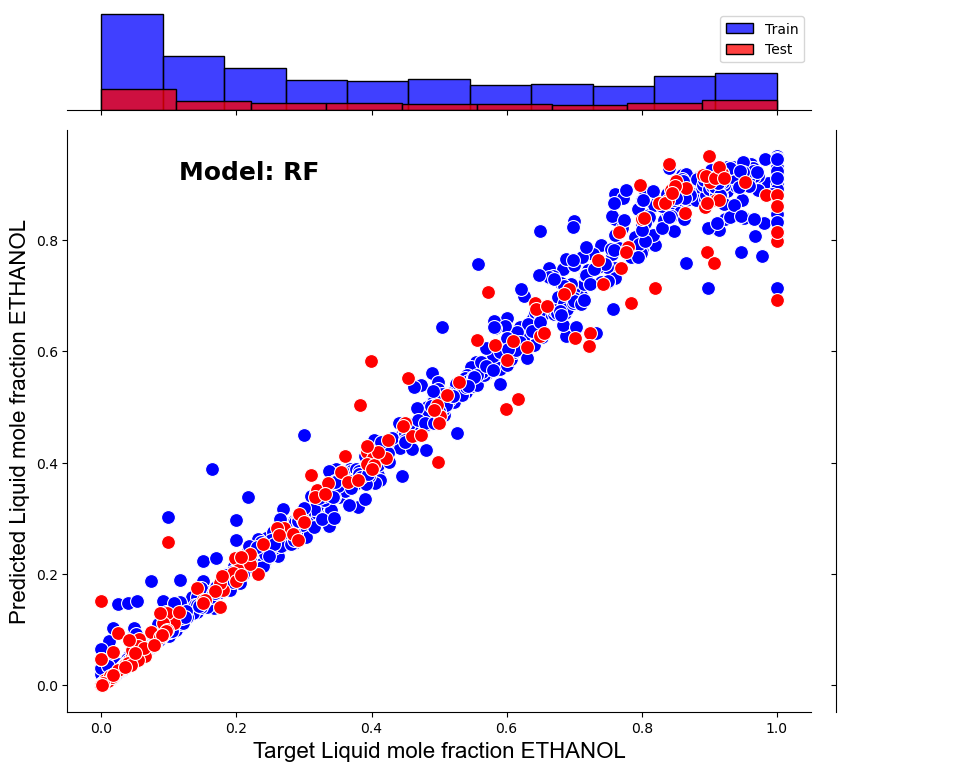

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 2 for the output Vapor mole fraction ETHANOL :

Number of samples in training set: 954.0 	 Number of sample in test set: 169.0 

	 Train R2: 0.982 

	 Test R2: 0.943

	 CV R2: 0.952 (+/- 0.007) 

	 Train RMSE: 0.033 

	 Test RMSE: 0.061

	 CV RMSE: 0.054 (+/- 0.005) 



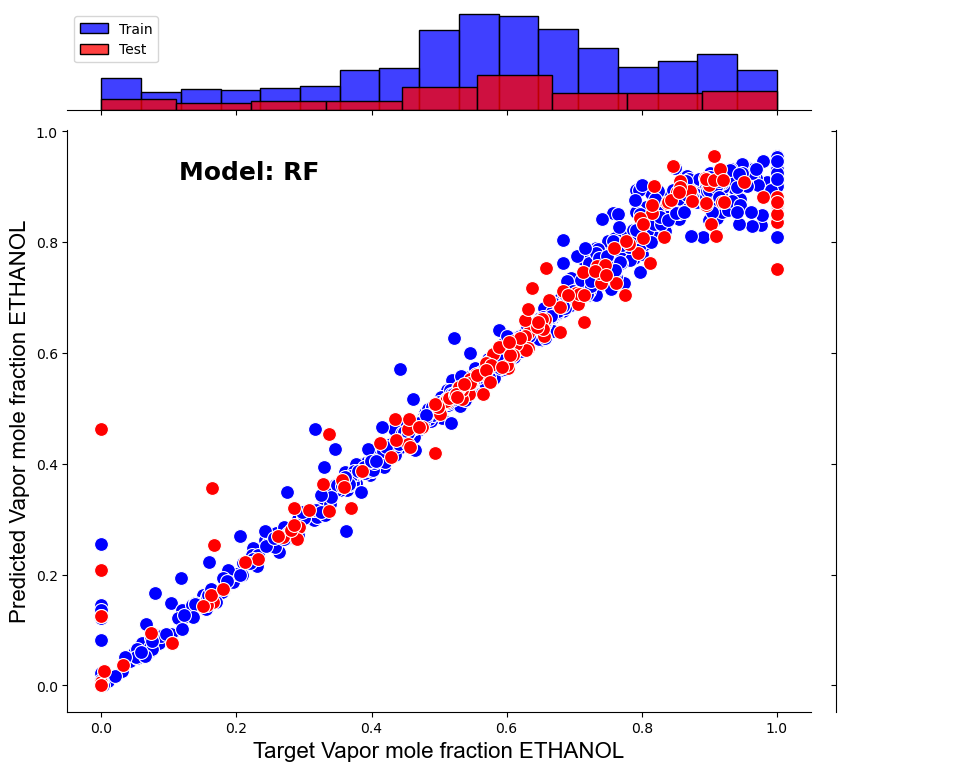

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Mean cross validated R2 value: 0.955 % 



In [7]:
RF_VLE = Algorithm_function(X_VLE, Y_VLE , modelname = 'RF', CV_folds = 5, optimisation = True , iterations_RandSearch = 'auto')

GBR model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 40824 

40 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 1 for the output Liquid mole fraction ETHANOL :

Number of samples in training set: 954.0 	 Number of sample in test set: 169.0 

	 Train R2: 0.991 

	 Test R2: 0.971

	 CV R2: 0.969 (+/- 0.002) 

	 Train RMSE: 0.030 

	 Test RMSE: 0.055

	 CV RMSE: 0.057 (+/- 0.002) 



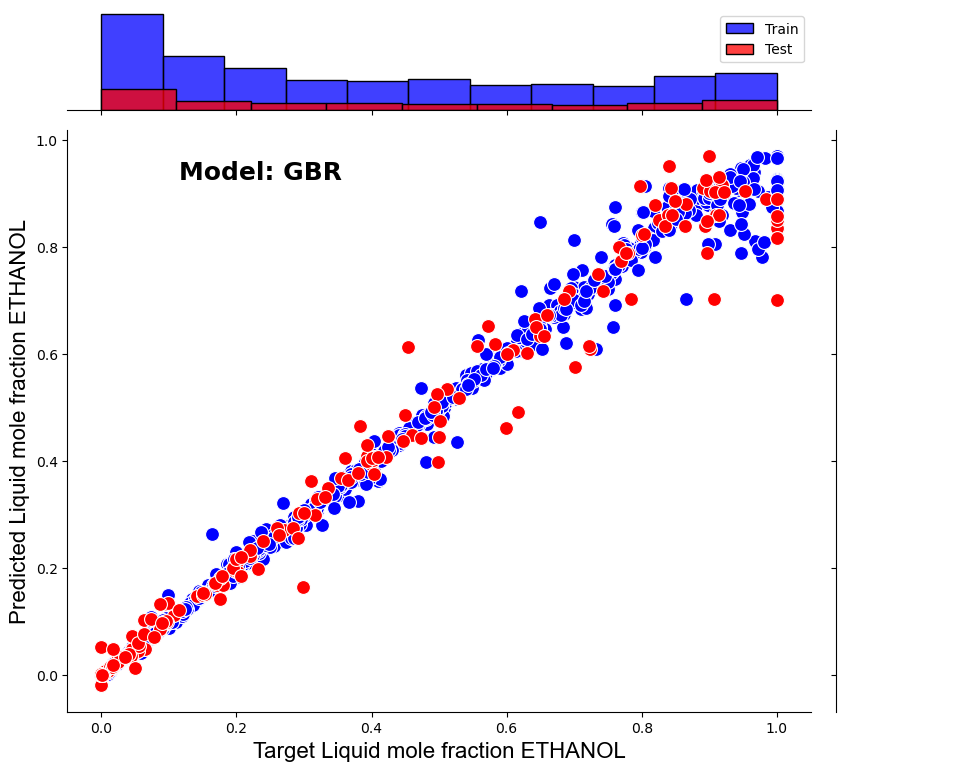

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 2 for the output Vapor mole fraction ETHANOL :

Number of samples in training set: 954.0 	 Number of sample in test set: 169.0 

	 Train R2: 0.992 

	 Test R2: 0.963

	 CV R2: 0.963 (+/- 0.006) 

	 Train RMSE: 0.022 

	 Test RMSE: 0.050

	 CV RMSE: 0.047 (+/- 0.004) 



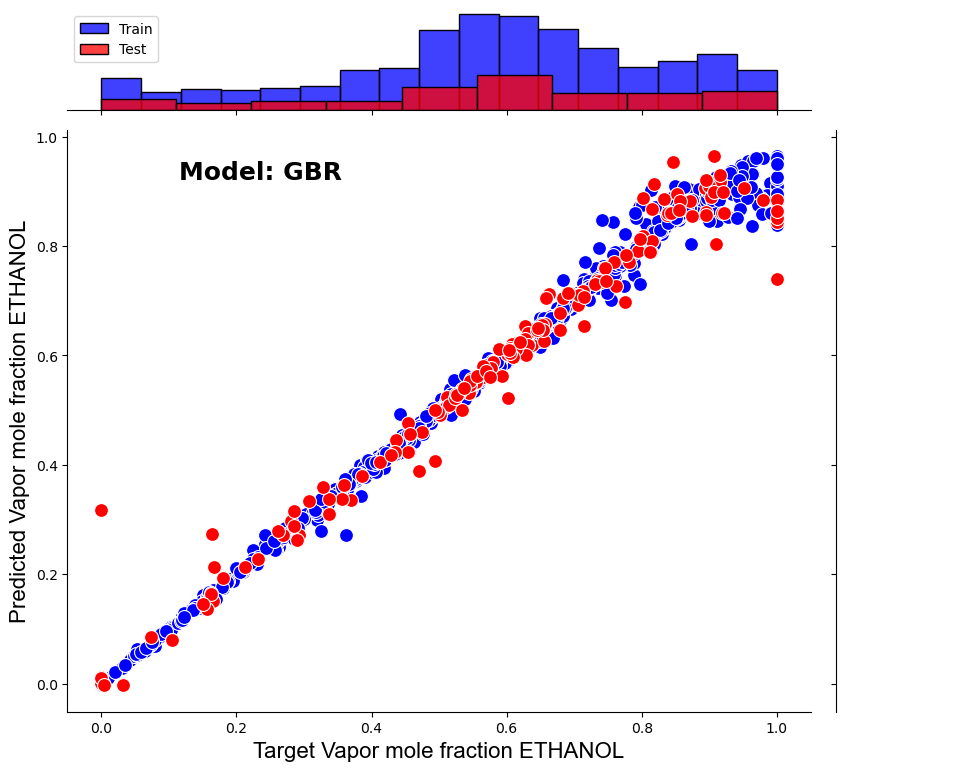

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Mean cross validated R2 value: 0.966 % 



In [8]:
GBR_VLE = Algorithm_function(X_VLE, Y_VLE, modelname = 'GBR', CV_folds = 5, optimisation = True , iterations_RandSearch = 'auto')

AdaBoost model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 630 

31 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 1 for the output Liquid mole fraction ETHANOL :

Number of samples in training set: 954.0 	 Number of sample in test set: 169.0 

	 Train R2: 0.994 

	 Test R2: 0.970

	 CV R2: 0.963 (+/- 0.006) 

	 Train RMSE: 0.024 

	 Test RMSE: 0.057

	 CV RMSE: 0.062 (+/- 0.004) 



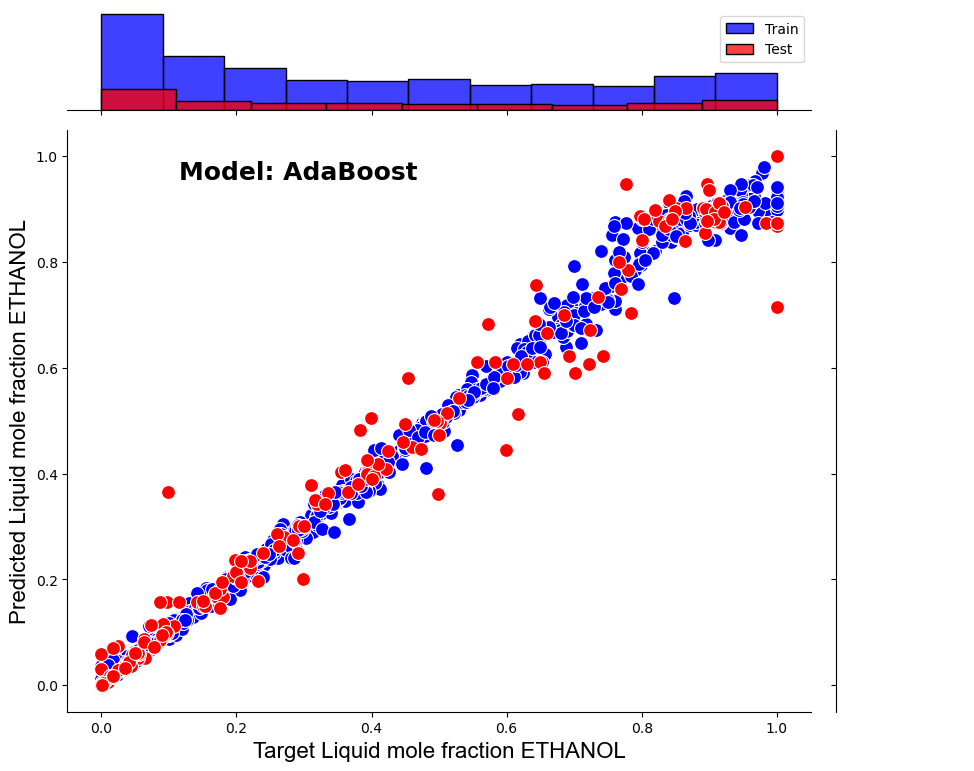

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 2 for the output Vapor mole fraction ETHANOL :

Number of samples in training set: 954.0 	 Number of sample in test set: 169.0 

	 Train R2: 0.989 

	 Test R2: 0.961

	 CV R2: 0.958 (+/- 0.008) 

	 Train RMSE: 0.025 

	 Test RMSE: 0.051

	 CV RMSE: 0.050 (+/- 0.005) 



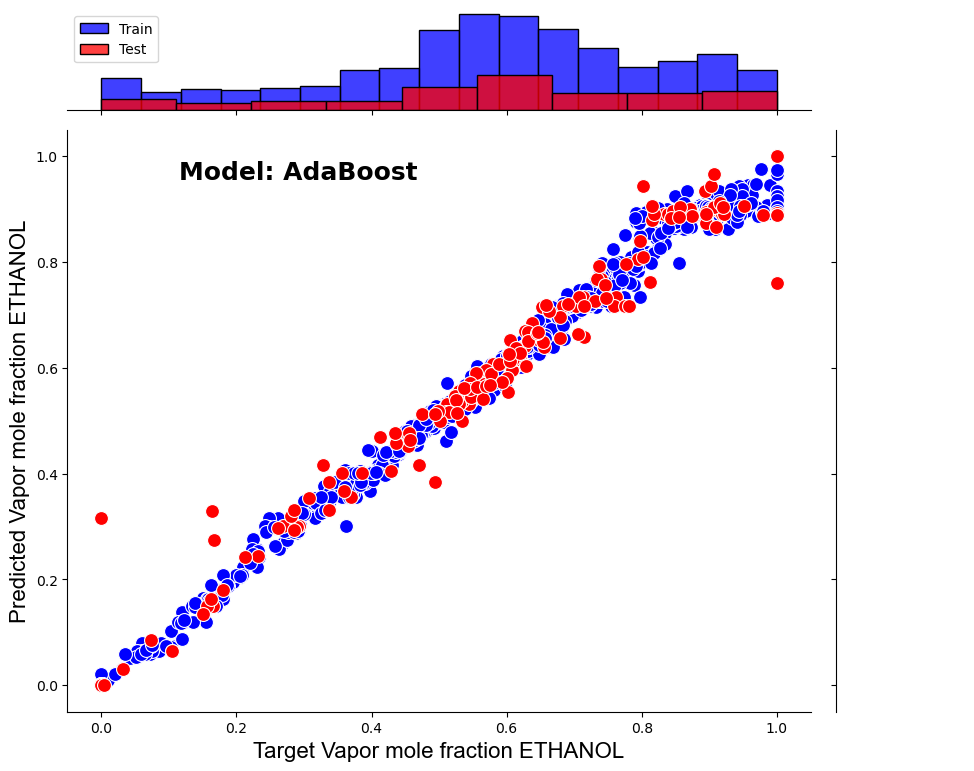

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Mean cross validated R2 value: 0.960 % 



In [9]:
AdaBoost_VLE = Algorithm_function(X_VLE, Y_VLE, modelname = 'AdaBoost', CV_folds = 5, optimisation = True , iterations_RandSearch = 'auto')

In [10]:
# Summary of key model scores (mean values shown - individual values shown in cell below)

# Select models to be stored
modellabels = ['RF','GBR', 'AdaBoost']

# Initialise dataframe
# CV R2
optmised_models_summary = pd.DataFrame(columns= modellabels, index = ['R2_CV', 'R2_test', 'RMSE_CV', 'RMSE_test'])
optmised_models_summary.loc['R2_CV']['RF'] = np.mean(RF_VLE.loc['R2_CV'])
optmised_models_summary.loc['R2_CV']['GBR'] = np.mean(GBR_VLE.loc['R2_CV'])
optmised_models_summary.loc['R2_CV']['AdaBoost'] = np.mean(AdaBoost_VLE.loc['R2_CV'])

# R2 for test set
optmised_models_summary.loc['R2_test']['RF'] = np.mean(RF_VLE.loc['R2_test'])
optmised_models_summary.loc['R2_test']['GBR'] = np.mean(GBR_VLE.loc['R2_test'])
optmised_models_summary.loc['R2_test']['AdaBoost'] = np.mean(AdaBoost_VLE.loc['R2_test'])

# CV RMSE
optmised_models_summary.loc['RMSE_CV']['RF'] = np.mean(RF_VLE.loc['RMSE_CV'])
optmised_models_summary.loc['RMSE_CV']['GBR'] = np.mean(GBR_VLE.loc['RMSE_CV'])
optmised_models_summary.loc['RMSE_CV']['AdaBoost'] = np.mean(AdaBoost_VLE.loc['RMSE_CV'])

# RMSE for test set
optmised_models_summary.loc['RMSE_test']['RF'] = np.mean(RF_VLE.loc['RMSE_test'])
optmised_models_summary.loc['RMSE_test']['GBR'] = np.mean(GBR_VLE.loc['RMSE_test'])
optmised_models_summary.loc['RMSE_test']['AdaBoost'] = np.mean(AdaBoost_VLE.loc['RMSE_test'])

# Display performance of models
optmised_models_summary

,RF,GBR,AdaBoost
R2_CV,0.955485,0.966063,0.960261
R2_test,0.955899,0.967088,0.965718
RMSE_CV,0.059211,0.051755,0.055949
RMSE_test,0.0597,0.0525,0.053584


In [11]:
# Summary of individual model scores

# List of output models to be columns of dataframe
modellabels = RF_VLE.columns

# Initialise dataframe
optmised_individual_models_summary = pd.DataFrame(columns= modellabels, index = ['RF_R2_CV', 'GBR_R2_CV', 'AdaBoost_R2_CV', # R2 CV
                                                                                 'RF_R2_test', 'GBR_R2_test', 'AdaBoost_R2_test', # R2 test
                                                                                 'RF_RMSE_CV', 'GBR_RMSE_CV', 'AdaBoost_RMSE_CV', # RMSE CV
                                                                                 'RF_RMSE_test', 'GBR_RMSE_test', 'AdaBoost_RMSE_test', # RMSE test
                                                                                ]) 
# CV R2
optmised_individual_models_summary.loc['RF_R2_CV'] = RF_VLE.loc['R2_CV']
optmised_individual_models_summary.loc['GBR_R2_CV'] = GBR_VLE.loc['R2_CV']
optmised_individual_models_summary.loc['AdaBoost_R2_CV'] = AdaBoost_VLE.loc['R2_CV']

# R2 for test set
optmised_individual_models_summary.loc['RF_R2_test'] = RF_VLE.loc['R2_test']
optmised_individual_models_summary.loc['GBR_R2_test'] = GBR_VLE.loc['R2_test']
optmised_individual_models_summary.loc['AdaBoost_R2_test'] = AdaBoost_VLE.loc['R2_test']

# CV RMSE
optmised_individual_models_summary.loc['RF_RMSE_CV'] = RF_VLE.loc['RMSE_CV']
optmised_individual_models_summary.loc['GBR_RMSE_CV'] = GBR_VLE.loc['RMSE_CV']
optmised_individual_models_summary.loc['AdaBoost_RMSE_CV'] = AdaBoost_VLE.loc['RMSE_CV']

# RMSE for test set
optmised_individual_models_summary.loc['RF_RMSE_test'] = RF_VLE.loc['RMSE_test']
optmised_individual_models_summary.loc['GBR_RMSE_test'] = GBR_VLE.loc['RMSE_test']
optmised_individual_models_summary.loc['AdaBoost_RMSE_test'] = AdaBoost_VLE.loc['RMSE_test']

# Display performance of models
optmised_individual_models_summary

,Liquid mole fraction ETHANOL,Vapor mole fraction ETHANOL
RF_R2_CV,0.958867,0.952103
GBR_R2_CV,0.968663,0.963463
AdaBoost_R2_CV,0.962525,0.957996
RF_R2_test,0.968388,0.94341
GBR_R2_test,0.971473,0.962703
AdaBoost_R2_test,0.970274,0.961161
RF_RMSE_CV,0.064851,0.053571
GBR_RMSE_CV,0.056827,0.046684
AdaBoost_RMSE_CV,0.061887,0.05001
RF_RMSE_test,0.058412,0.060988


In [12]:
# Define prerequisite functions used within the plotting function:

# Create Function to scale values in array to choosen range:
def ScaleArray(array, lower_bound = 0, upper_bound = 1):
    scaled_array = lower_bound + (array - np.min(array)) / (np.max(array) - np.min(array))*(upper_bound - lower_bound)
    return scaled_array

# Create function that splits array in half:
def SplitArray(array):
    half = len(array)//2
    FirstHalf = array[:half]
    SecondHalf = array[half:]
    return FirstHalf, SecondHalf

In [13]:
def ScatterAll(performance_summary, modeltype):
         

    # Initialise Figure 
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    

    marker_styles = np.array(['o'] *performance_summary.columns.shape[0])
    
    # Loop to extract, scale, and plot values
    for column in np.arange(performance_summary.columns.shape[0]):

        # Extract predictions and targets
        predictions = performance_summary.iloc[:,column]['test_predictions']
        targets = np.array(performance_summary.iloc[:,column]['test_targets'])
        combined_array = np.concatenate((targets, predictions)) # combined to scale together 
        scaled_array = ScaleArray(combined_array)
        scaled_predictions, scaled_targets =  SplitArray(scaled_array)

        # Extract correspoding label and marker styles
        legend_label = np.array(RF_VLE.columns)[column]
        
        marker = marker_styles[column]
            
        # Plot predictions vs. targets
        ax1.scatter(scaled_targets, scaled_predictions, marker=marker, label=legend_label, s=50, alpha=0.7, zorder=3)
    
    # Configure graph
    plt.legend(loc='best');
    plt.legend([r'Predicted Liquid mole fraction ETHANOL',
                r'Predicted Vapor mole fraction ETHANOL',
               ])

    plt.xlabel('Scaled Targets', fontsize= 18)
    plt.ylabel('Scaled Predictions', fontsize= 18)
    
    # Add best fit line
    line = np.linspace(min(scaled_array),max(scaled_array))
    ax1.plot(line, line,color = 'black', linewidth=1.5, linestyle='dashed', zorder=4)
    
    # Add error regions
    ax1.fill_between(line, line - 0.1, line + 0.1,color ='blue', alpha = 0.1, zorder=1) # 10% error
    ax1.fill_between(line, line - 0.2, line + 0.2,color ='red', alpha = 0.08, zorder=2) # 20% error
    
    # Add title
    plt.title(f"Model: {modeltype}", fontsize=20, loc='left')
    
    # Save plot
    #folder_path = r"D:\University\دروس\ارشد\ترمودینامیک پیشرفته\Project\Plots"
    #filename = f"mix_plot_VLE_{modeltype}.png"
    #filepath = os.path.join(folder_path, filename)
    #plt.savefig(filepath , dpi=500)

        
    plt.show()
    

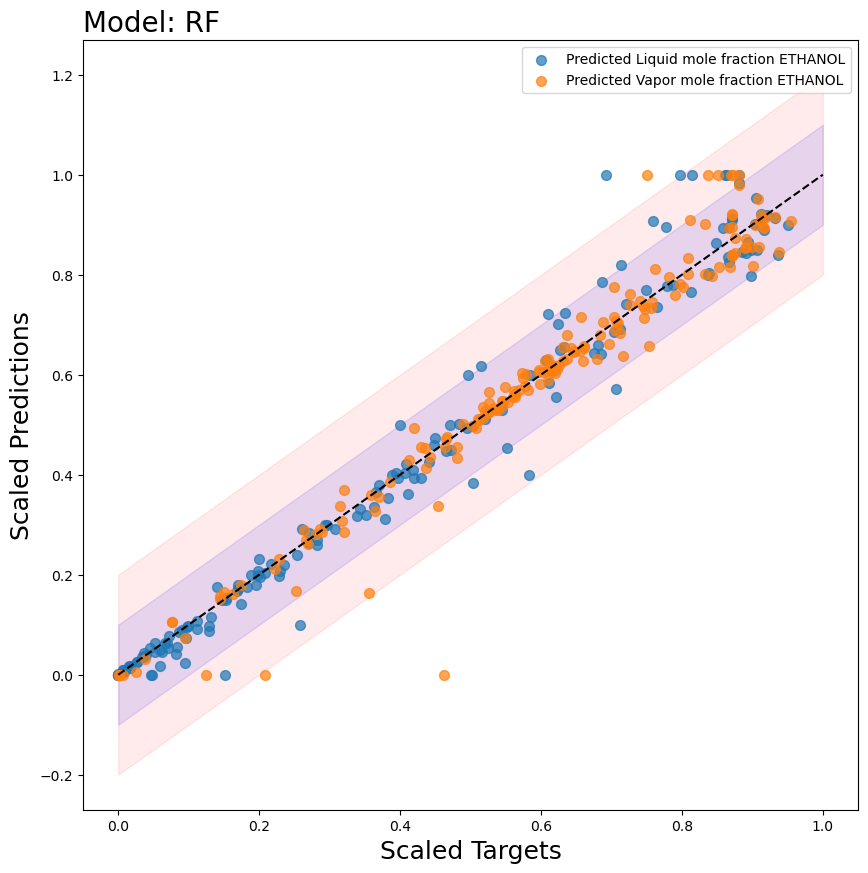

In [14]:
# RF
ScatterAll(performance_summary=RF_VLE, modeltype='RF')

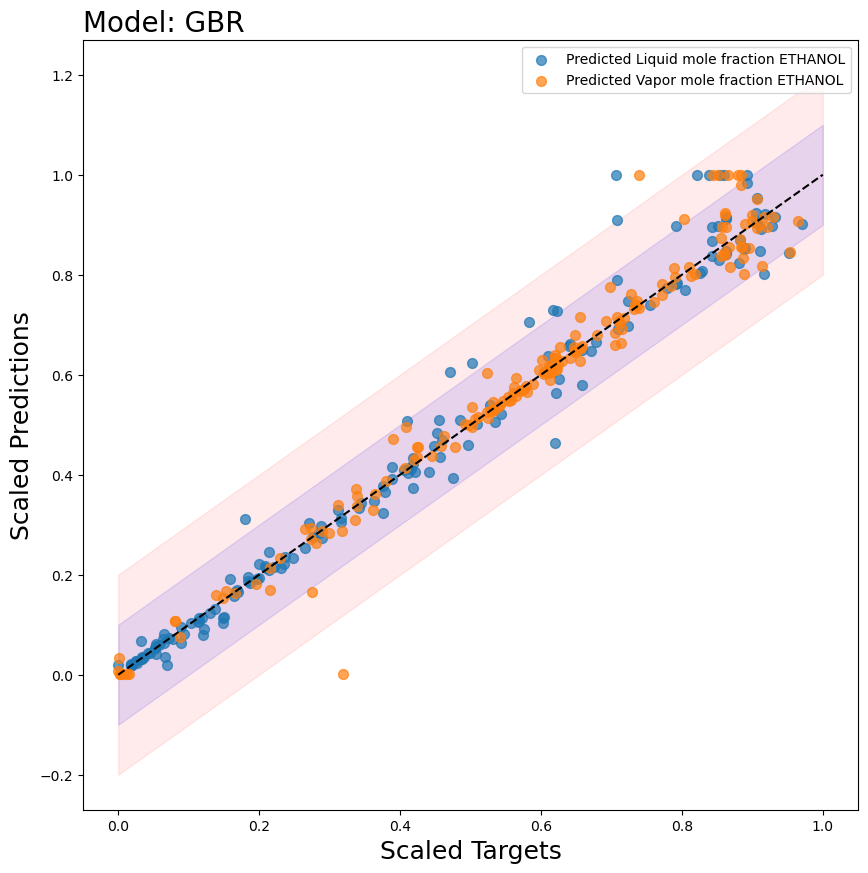

In [15]:
# GBR
ScatterAll(performance_summary=GBR_VLE, modeltype='GBR')

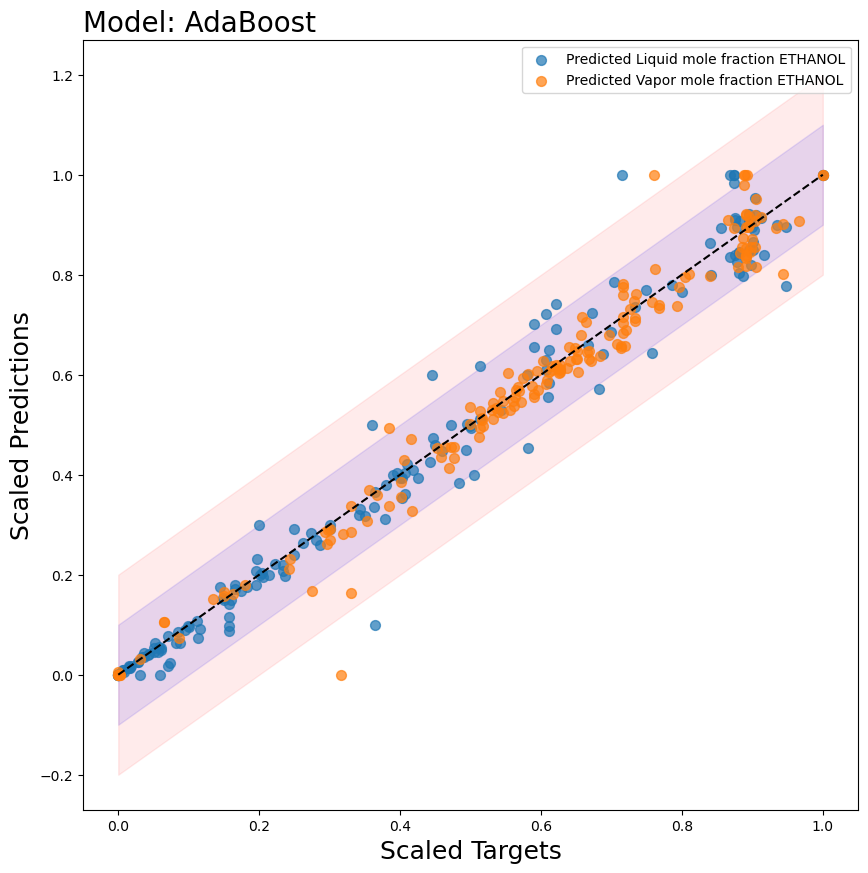

In [16]:
# Adaboost
ScatterAll(performance_summary=AdaBoost_VLE, modeltype='AdaBoost')

#### 4-2) Results for Thermal Conductivity

RF model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 1386 

13 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 1 for the output Thermal conductivity (Watt/m-K) :

Number of samples in training set: 1086.0 	 Number of sample in test set: 192.0 

	 Train R2: 0.997 

	 Test R2: 0.988

	 CV R2: 0.992 (+/- 0.002) 

	 Train RMSE: 0.007 

	 Test RMSE: 0.014

	 CV RMSE: 0.011 (+/- 0.001) 



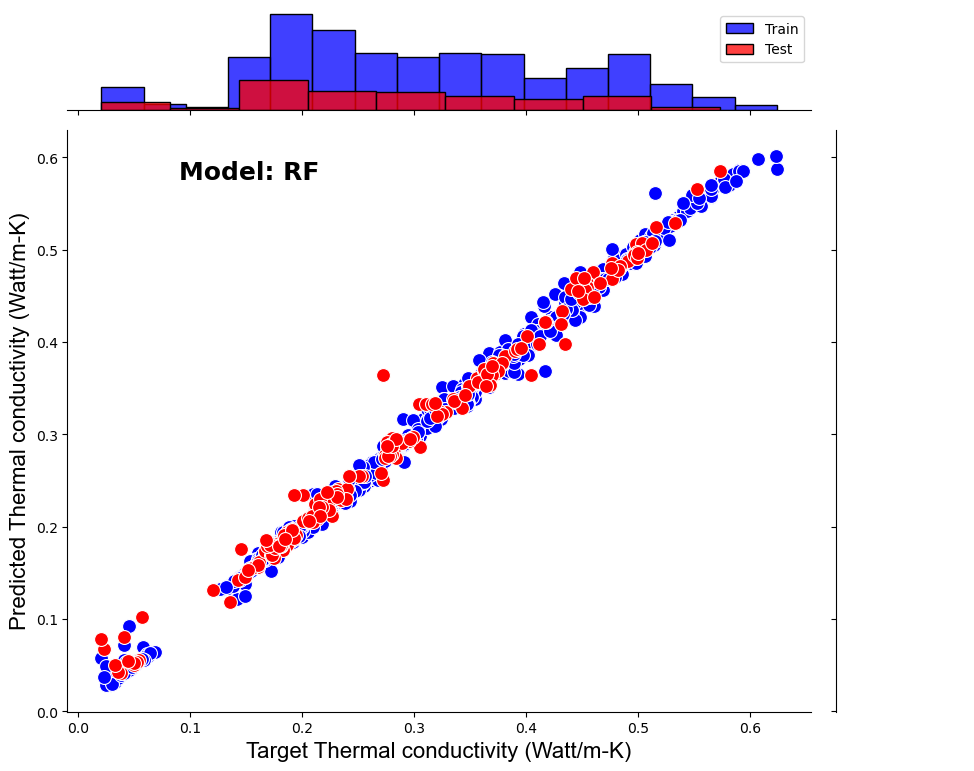

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



In [17]:
RF_TC = Algorithm_function(X_TC, Y_TC , modelname = 'RF', CV_folds = 5, optimisation = True , iterations_RandSearch = 'auto')

GBR model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 40824 

40 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 1 for the output Thermal conductivity (Watt/m-K) :

Number of samples in training set: 1086.0 	 Number of sample in test set: 192.0 

	 Train R2: 1.000 

	 Test R2: 0.993

	 CV R2: 0.995 (+/- 0.001) 

	 Train RMSE: 0.003 

	 Test RMSE: 0.011

	 CV RMSE: 0.009 (+/- 0.001) 



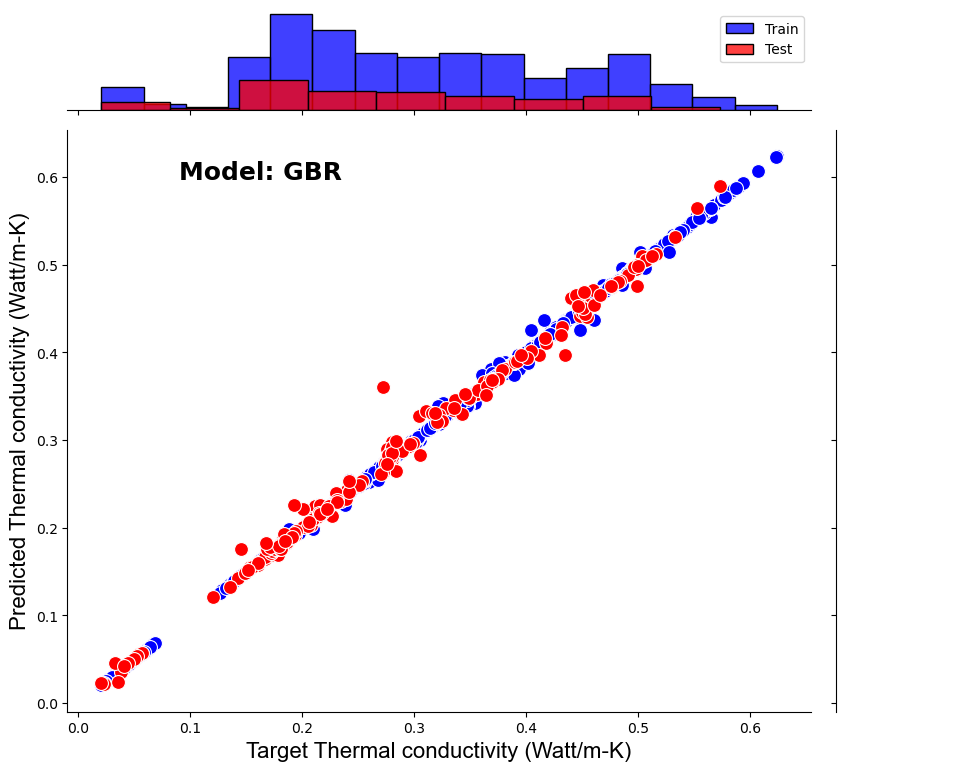

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



In [18]:
GBR_TC = Algorithm_function(X_TC, Y_TC , modelname = 'GBR', CV_folds = 5, optimisation = True , iterations_RandSearch = 'auto')

AdaBoost model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 630 

31 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 1 for the output Thermal conductivity (Watt/m-K) :

Number of samples in training set: 1086.0 	 Number of sample in test set: 192.0 

	 Train R2: 0.999 

	 Test R2: 0.991

	 CV R2: 0.995 (+/- 0.001) 

	 Train RMSE: 0.005 

	 Test RMSE: 0.012

	 CV RMSE: 0.010 (+/- 0.001) 



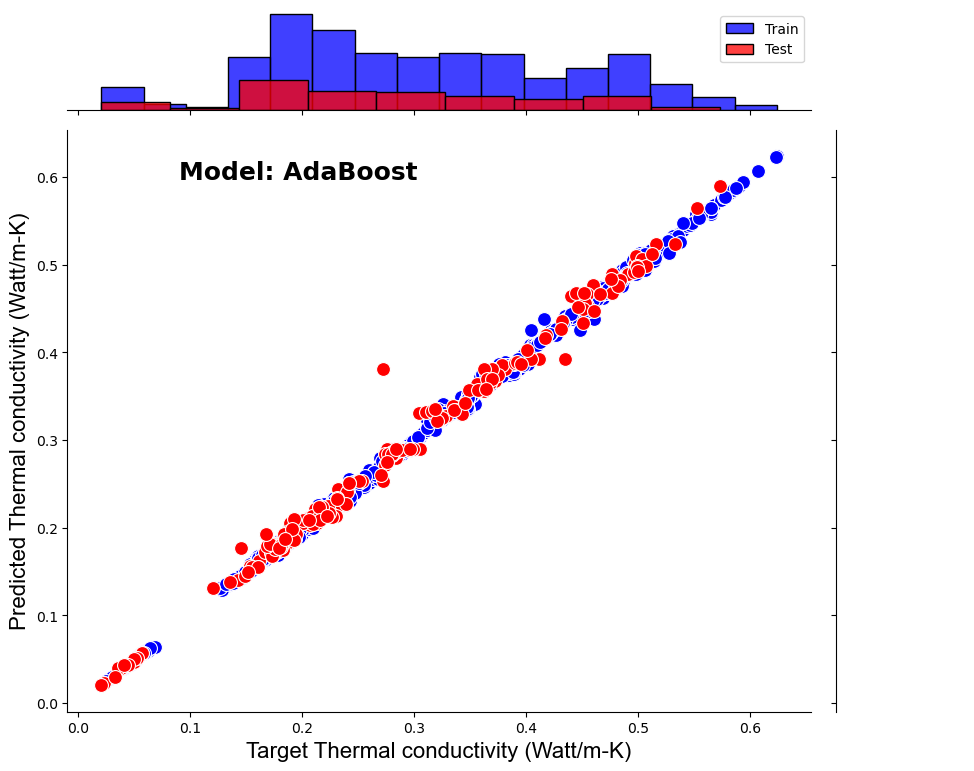

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



In [19]:
AdaBoost_TC = Algorithm_function(X_TC, Y_TC , modelname = 'AdaBoost', CV_folds = 5, optimisation = True , iterations_RandSearch = 'auto')

In [20]:
# Summary of individual model scores

# List of output models to be columns of dataframe
modellabels = RF_TC.columns

# Initialise dataframe
optmised_individual_models_summary = pd.DataFrame(columns= modellabels, index = ['RF_R2_CV', 'GBR_R2_CV', 'AdaBoost_R2_CV', # R2 CV
                                                                                 'RF_R2_test', 'GBR_R2_test', 'AdaBoost_R2_test', # R2 test
                                                                                 'RF_RMSE_CV', 'GBR_RMSE_CV', 'AdaBoost_RMSE_CV', # RMSE CV
                                                                                 'RF_RMSE_test', 'GBR_RMSE_test', 'AdaBoost_RMSE_test', # RMSE test
                                                                                ]) 
# CV R2
optmised_individual_models_summary.loc['RF_R2_CV'] = RF_TC.loc['R2_CV']
optmised_individual_models_summary.loc['GBR_R2_CV'] = GBR_TC.loc['R2_CV']
optmised_individual_models_summary.loc['AdaBoost_R2_CV'] = AdaBoost_TC.loc['R2_CV']

# R2 for test set
optmised_individual_models_summary.loc['RF_R2_test'] = RF_TC.loc['R2_test']
optmised_individual_models_summary.loc['GBR_R2_test'] = GBR_TC.loc['R2_test']
optmised_individual_models_summary.loc['AdaBoost_R2_test'] = AdaBoost_TC.loc['R2_test']

# CV RMSE
optmised_individual_models_summary.loc['RF_RMSE_CV'] = RF_TC.loc['RMSE_CV']
optmised_individual_models_summary.loc['GBR_RMSE_CV'] = GBR_TC.loc['RMSE_CV']
optmised_individual_models_summary.loc['AdaBoost_RMSE_CV'] = AdaBoost_TC.loc['RMSE_CV']

# RMSE for test set
optmised_individual_models_summary.loc['RF_RMSE_test'] = RF_TC.loc['RMSE_test']
optmised_individual_models_summary.loc['GBR_RMSE_test'] = GBR_TC.loc['RMSE_test']
optmised_individual_models_summary.loc['AdaBoost_RMSE_test'] = AdaBoost_TC.loc['RMSE_test']

# Display performance of models
optmised_individual_models_summary

,Thermal conductivity (Watt/m-K)
RF_R2_CV,0.992234
GBR_R2_CV,0.994889
AdaBoost_R2_CV,0.994502
RF_R2_test,0.988184
GBR_R2_test,0.99323
AdaBoost_R2_test,0.99112
RF_RMSE_CV,0.011374
GBR_RMSE_CV,0.009227
AdaBoost_RMSE_CV,0.009611
RF_RMSE_test,0.01389
